# Python для Data Science 2.1 - курсовой проект
<br>

## Оглавление<a class="anchor" id="content"></a>
---

1. [Цель курсового проекта](#target)
2. [Метрика соревнования](#metric)
3. [Описание датасета](#description)
4. [Подключение библиотек](#libs)
5. [Полезные функции](#functions)
6. [Загрузка датасета](#dataset)
7. [Исследование и обработка данных](#research)
8. [Обработка пропусков](#gap)
9. [Отбор признаков и разбиение данных](#split)
10. [Построение модели](#model)
11. [Подбор лучшей модели CatBoost¶](#best_model)
12. [Предсказание на тестовых данных](#prediction)
<br><br>

## 1. Цель курсового проекта<a class="anchor" id="target"></a>
---
Цель курсового проекта - получить score больше 0.5 на в соревновании <a href="https://www.kaggle.com/c/654pds2courseproject/overview">Loan Default Prediction</a>.<br>
Задача соревнования - предсказать, отдаст ли заемщик кредит для датасета test.csv

<br>

## 2. Метрика соревнования
---

Метрика для оценки – коэффициент детерминации: <br>
$$F1 = 2 \cdot \frac{precision \cdot recall}{precision + recall} = \frac{TP}{TP + \frac{1}{2} \cdot (FP + FN)}$$

---
[Наверх](#content)

## 3. Описание датасета<a class="anchor" id="description"></a>
---
### Файлы
`train.csv` - the training set <br>
`test.csv` - the test set <br>
`sampleSubmission.csv` - a sample submission file in the correct format <br>

### Столбцы
- Home Ownership - домовладение
- Annual Income - годовой доход
- Years in current job - количество лет на текущем месте работы
- Tax Liens - налоговые обременения
- Number of Open Accounts - количество открытых счетов
- Years of Credit History - количество лет кредитной истории
- Maximum Open Credit - наибольший открытый кредит
- Number of Credit Problems - количество проблем с кредитом
- Months since last delinquent - количество месяцев с последней просрочки платежа
- Bankruptcies - банкротства
- Purpose - цель кредита
- Term - срок кредита
- Current Loan Amount - текущая сумма кредита
- Current Credit Balance - текущий кредитный баланс
- Monthly Debt - ежемесячный долг
- Credit Score - баллы кредитного рейтинга
- Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

---
[Наверх](#content)

## 4. Подключение библиотек<a class="anchor" id="libs"></a>
---

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import random
import pickle
from pathlib import Path

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingRegressor
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

from joblib import parallel_backend 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
TRAIN_DATASET_PATH = '../datasets/competition/train.csv'
TEST_DATASET_PATH = '../datasets/competition/test.csv'
SUBMISSION_PATH = '../datasets/competition/'

---
[Наверх](#content)

## 5. Полезные функции<a class="anchor" id="functions"></a>
---

In [4]:
def sns_kdeplot_compare(df_train, df_test, ncol=2):
    
    assert ncol > 1
    
    feature_columns = list(set(df_train.columns) and set(df_test.columns))
    feature_columns.sort()
    
    nrow = len(feature_columns)//ncol + 1
    plt.figure(figsize=(16, 8 * nrow))
    
    sns.set(font_scale=1.2)
    
    for i, feature in enumerate(feature_columns):
        plt.subplot(nrow, ncol, i + 1)
        sns.kdeplot(df_train[feature], shade=True, label='train', color='g')
        sns.kdeplot(df_test[feature], shade=True, label='test', color='r')

    plt.show()

In [5]:
def sns_matrix_corr(df, method='pearson', corr_rel=0, num_round=2, cmap='viridis'):

    methods = {'pearson', 'kendall', 'spearman'}
    
    assert corr_rel > 0 or corr_rel == 0, 'corr_rel должен быть больше и равен 0'
    assert num_round > 0, 'num_round должен быть не менее 1'
    assert method in methods, f"method допускает следующие значения {methods}"
    
    correlation_matrix = np.round(df.corr(method=method), num_round)
    
    if not corr_rel is None:
        correlation_matrix[np.abs(correlation_matrix) < corr_rel] = 0

    mask = np.zeros_like(correlation_matrix, dtype=np.bool)
    mask[np.triu_indices(correlation_matrix.shape[0])] = True

    plt.figure(figsize = (16, 16))
    sns.set(font_scale=1.2)
    sns.heatmap(correlation_matrix, mask=mask, annot=True, linewidths=0.2, cmap=cmap)
    plt.title('Correlation matrix')
    plt.show()

In [6]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [7]:
def clf_evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

---
[Наверх](#content)

## 6. Загрузка датасета<a class="anchor" id="dataset"></a>
---

In [8]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [9]:
df_train.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0
7499,Rent,NaN,4 years,0.0,8.0,9.4,480832.0,0.0,NaN,0.0,debt consolidation,Short Term,26928.0,288192.0,9061.0,NaN,0


In [10]:
df_test.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,NaN,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0
2499,Rent,1694439.0,10+ years,0.0,12.0,18.4,1199748.0,1.0,72.0,0.0,debt consolidation,Long Term,763004.0,559531.0,23440.0,6820.0


---
[Наверх](#content)

## 7. Исследование и обработка данных<a class="anchor" id="research"></a>
---

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [12]:
df_train.select_dtypes(np.float64).isna().sum()

Annual Income                   1557
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
dtype: int64

In [14]:
train_home_ownership = df_train['Home Ownership'].unique()
train_home_ownership.sort()
train_years_in_current_job = df_train['Years in current job'].unique()
train_purpose = df_train['Purpose'].unique()
train_purpose.sort()
train_term = df_train['Term'].unique()
train_term.sort()

print(f"Home Ownership uniques:\t{train_home_ownership.tolist()}\n")
print(f"Years in current job uniques:\t{train_years_in_current_job.tolist()}\n")
print(f"Purpose uniques:\t{train_purpose.tolist()}\n")
print(f"Term uniques:\t{train_term.tolist()}\n")

Home Ownership uniques:	['Have Mortgage', 'Home Mortgage', 'Own Home', 'Rent']

Years in current job uniques:	[nan, '10+ years', '8 years', '6 years', '7 years', '5 years', '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years']

Purpose uniques:	['business loan', 'buy a car', 'buy house', 'debt consolidation', 'educational expenses', 'home improvements', 'major purchase', 'medical bills', 'moving', 'other', 'renewable energy', 'small business', 'take a trip', 'vacation', 'wedding']

Term uniques:	['Long Term', 'Short Term']



*Для дальнейшего анализа необходимо произвести замену строковых данных цифровыми*

In [15]:
years_in_current_job_keys = {
    'nan': np.NaN,
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10,
}

home_ownership_keys = {key: value + 1 for value, key in enumerate(train_home_ownership)}
purpose_keys = {key: value + 1 for value, key in enumerate(train_purpose)}
term_keys = {key: value + 1 for value, key in enumerate(train_term)}

In [16]:
df_train['Home Ownership'].replace(home_ownership_keys, inplace=True)
df_train['Years in current job'].replace(years_in_current_job_keys, inplace=True)
df_train['Purpose'].replace(purpose_keys, inplace=True)
df_train['Term'].replace(term_keys, inplace=True)

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   int64  
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   float64
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   int64  
 11  Term                          7500 non-null   int64  
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

*Проверяем аналогичные столбцы тестового датасета*

In [18]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [19]:
test_home_ownership = df_test['Home Ownership'].unique()
test_years_in_current_job = df_test['Years in current job'].unique()
test_purpose = df_test['Purpose'].unique()
test_term = df_test['Term'].unique()

In [20]:
(set(test_home_ownership) == set(train_home_ownership)),\
(set(test_years_in_current_job) == set(train_years_in_current_job)),\
(set(test_purpose) == set(test_purpose)),\
(set(test_term) == set(test_term))

(True, True, True, True)

In [21]:
df_test['Home Ownership'].replace(home_ownership_keys, inplace=True)
df_test['Years in current job'].replace(years_in_current_job_keys, inplace=True)
df_test['Purpose'].replace(purpose_keys, inplace=True)
df_test['Term'].replace(term_keys, inplace=True)

***Построение графиков***

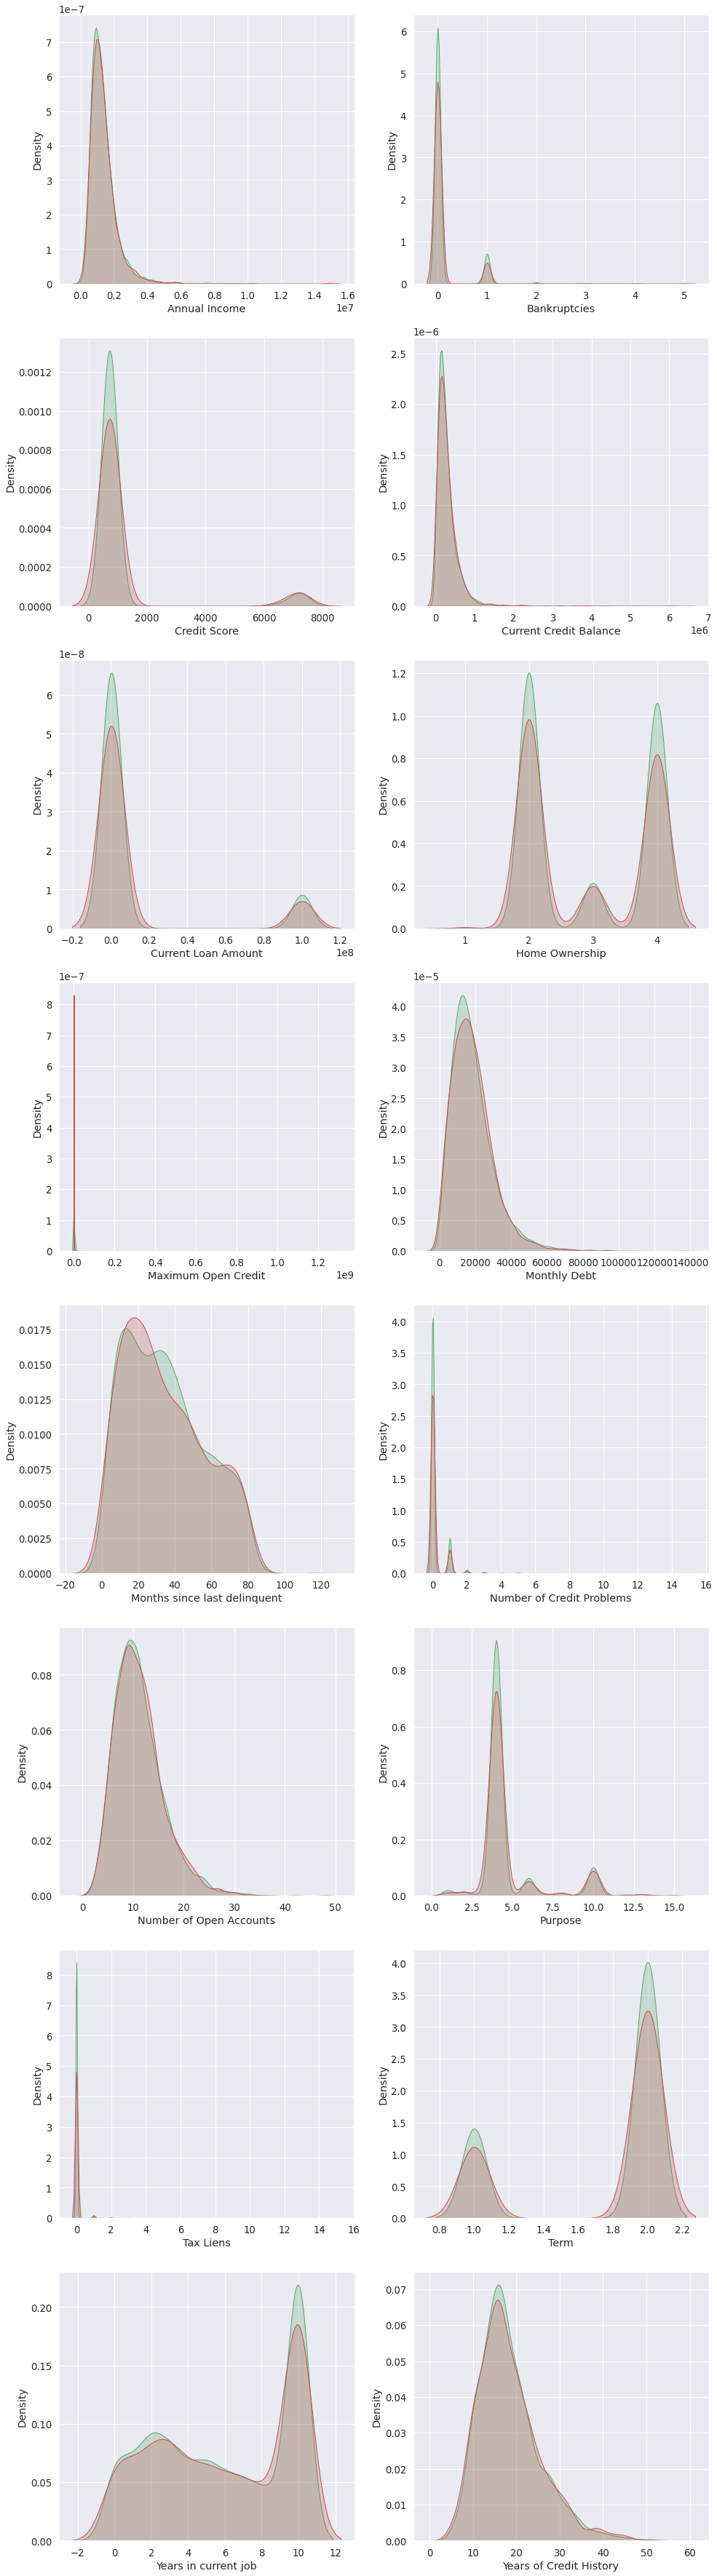

In [22]:
sns_kdeplot_compare(df_train, df_test)

***Для построения информативного boxplot сгруппируем фичи по максимальным величинам***

In [23]:
FEATURES_BOXPLOT = [
    ['Annual Income', 'Current Credit Balance'],
    ['Current Loan Amount', 'Maximum Open Credit'],
    ['Monthly Debt'],
    ['Credit Score'],
    ['Months since last delinquent'],
    ['Number of Open Accounts', 'Years of Credit History']
]

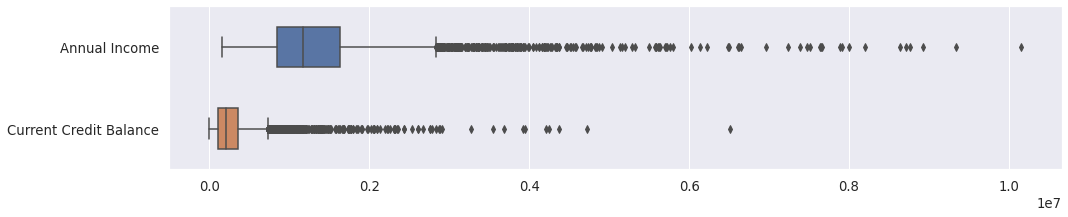

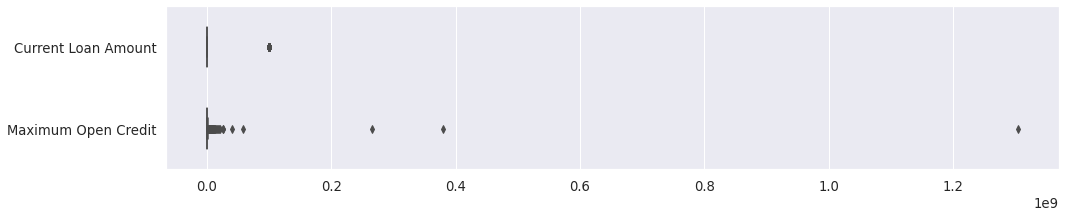

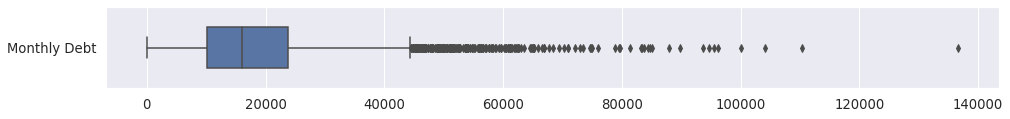

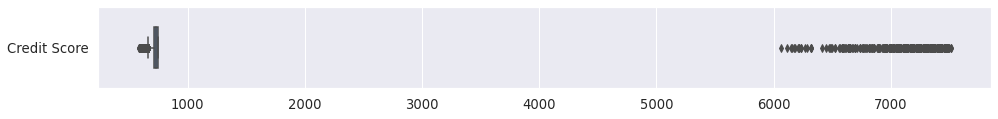

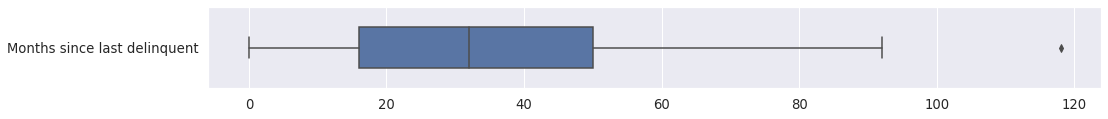

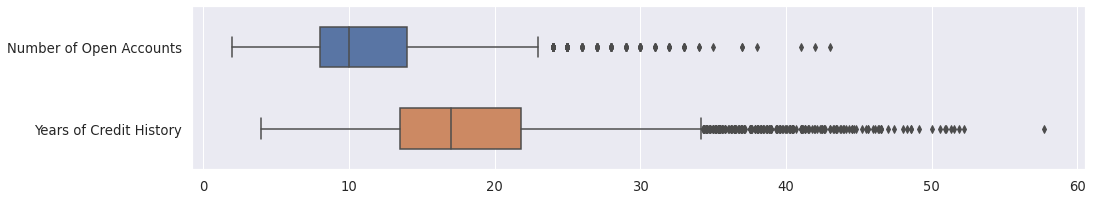

In [24]:
for FEATURES in FEATURES_BOXPLOT:
    plt.figure(figsize=(16, 1.5*len(FEATURES)))
    sns.boxplot(data=df_train[FEATURES], width=0.5, orient='h')
    plt.show()

***Бессмысленно визуализировать с помощью boxplot категориальные данные, такие как:***

```
'Home Ownership'
'Bankruptcies'
'Number of Credit Problems'
'Purpose'
'Tax Liens'
'Term'
'Years in current job'
```

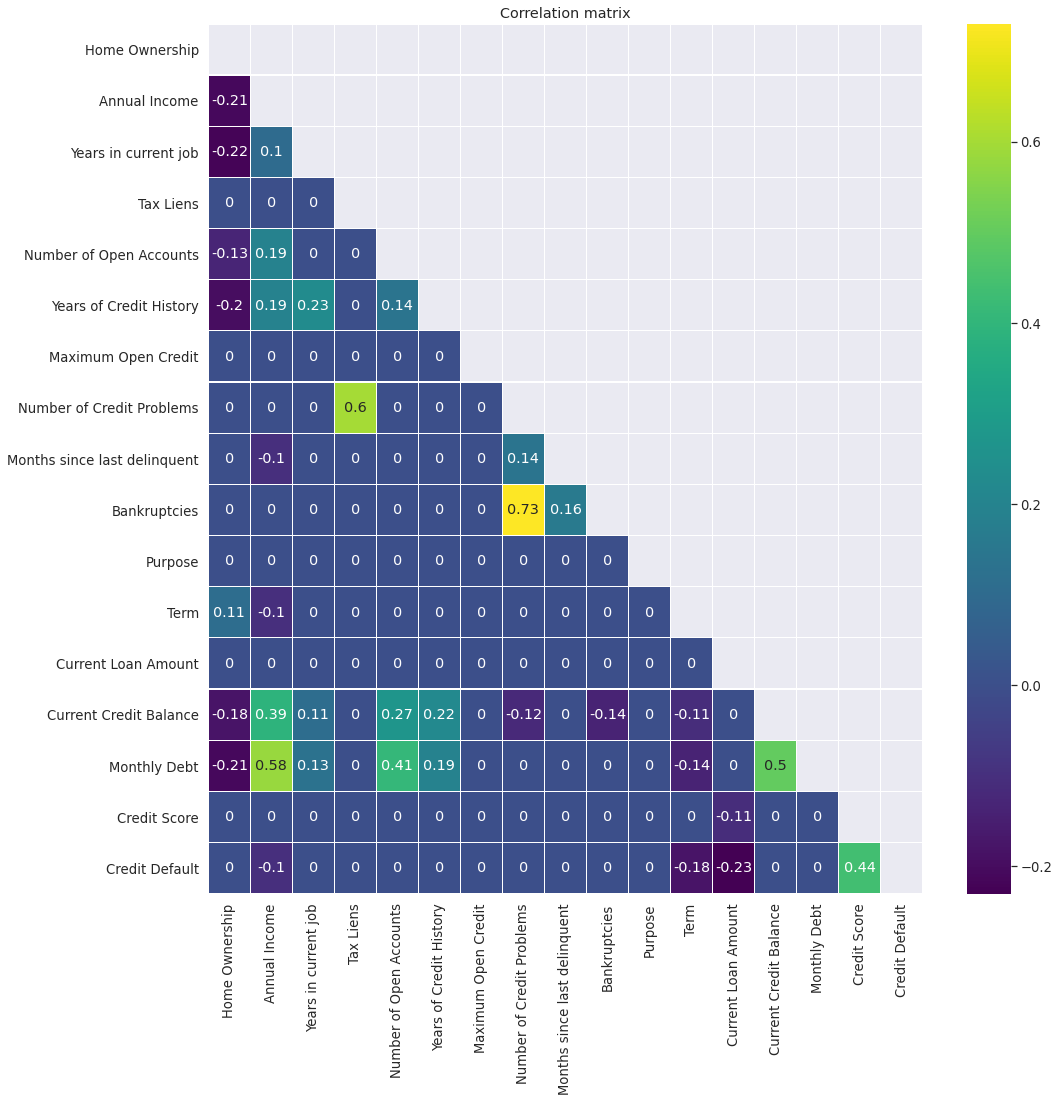

In [25]:
sns_matrix_corr(df_train, method='pearson', corr_rel=0.1)

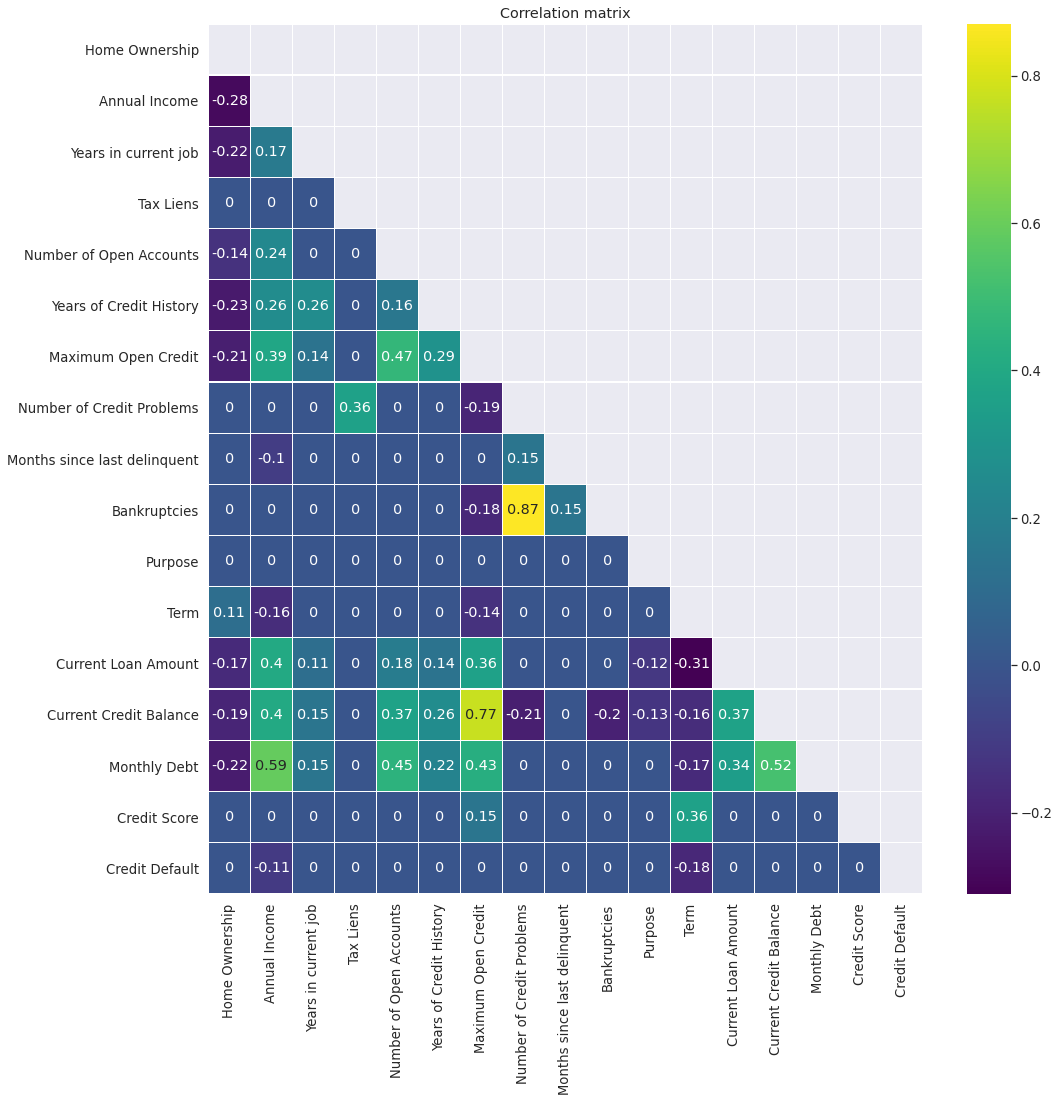

In [26]:
sns_matrix_corr(df_train, method='spearman', corr_rel=0.1)

In [38]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

***Выводы***

*1. Фичи с подозрением на выбросы (требуется дополнительный анализ):*
```
'Annual Income', 
'Current Credit Balance',
'Current Loan Amount',
'Maximum Open Credit',
'Monthly Debt',
'Credit Score',
```

*2. Фичи которые требуется проверить на схожесть на train и test:*
```
'Bankruptcies'
'Credit Score'
'Current Loan Amount'
'Home Ownership'
'Maximum Open Credit'
'Months since last delinquent'
'Number of Credit Problems'
'Purpose'
'Tax Liens'
'Term'
'Years in current job'
```

*3. Обратить внимание на корреляцию признаков*

*4. Заполнить недостающие данные*

*5. Обработать/убрать дисбаланс классов целевого столбца*

---
[Наверх](#content)

## 8. Обработка пропусков<a class="anchor" id="gap"></a>
---

In [28]:
df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [29]:
annual_income_median = df_train['Annual Income'].median()
years_in_current_job_median = df_train['Years in current job'].median()
months_since_last_delinquent_median = df_train['Months since last delinquent'].median()
bankruptcies_median = df_train['Bankruptcies'].median()
credit_score_median = df_train['Credit Score'].median()

In [30]:
df_train['Annual Income'].fillna(annual_income_median, inplace=True)
df_train['Years in current job'].fillna(years_in_current_job_median, inplace=True)
df_train['Months since last delinquent'].fillna(months_since_last_delinquent_median, inplace=True)
df_train['Bankruptcies'].fillna(bankruptcies_median, inplace=True)
df_train['Credit Score'].fillna(credit_score_median, inplace=True)

In [31]:
df_test['Annual Income'].fillna(annual_income_median, inplace=True)
df_test['Years in current job'].fillna(years_in_current_job_median, inplace=True)
df_test['Months since last delinquent'].fillna(months_since_last_delinquent_median, inplace=True)
df_test['Bankruptcies'].fillna(bankruptcies_median, inplace=True)
df_test['Credit Score'].fillna(credit_score_median, inplace=True)

In [32]:
df_train.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

In [33]:
df_test.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

---
[Наверх](#content)

## 9. Отбор признаков и разбиение данных<a class="anchor" id="split"></a>
---

### Отбор признаков<a class="anchor" id="feature_selection"></a>

In [39]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
# NEW_FEATURE_NAMES = df_new_features.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

In [40]:
BASE_FEATURE_NAMES

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [41]:
NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                     'Months since last delinquent', 'Current Loan Amount', 'Current Credit Balance', 
                     'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems',
                     'Bankruptcies', 'Purpose', 'Term']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES# + NEW_FEATURE_NAMES

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [42]:
X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.2,
                                                      random_state=42,
                                                      shuffle=True,
                                                      stratify=y)

X_test = df_test[SELECTED_FEATURE_NAMES]

display(y_train.value_counts(normalize=True), y_valid.value_counts(normalize=True))

0    0.718333
1    0.281667
Name: Credit Default, dtype: float64

0    0.718
1    0.282
Name: Credit Default, dtype: float64

*Контроль корректности разбиения данных*

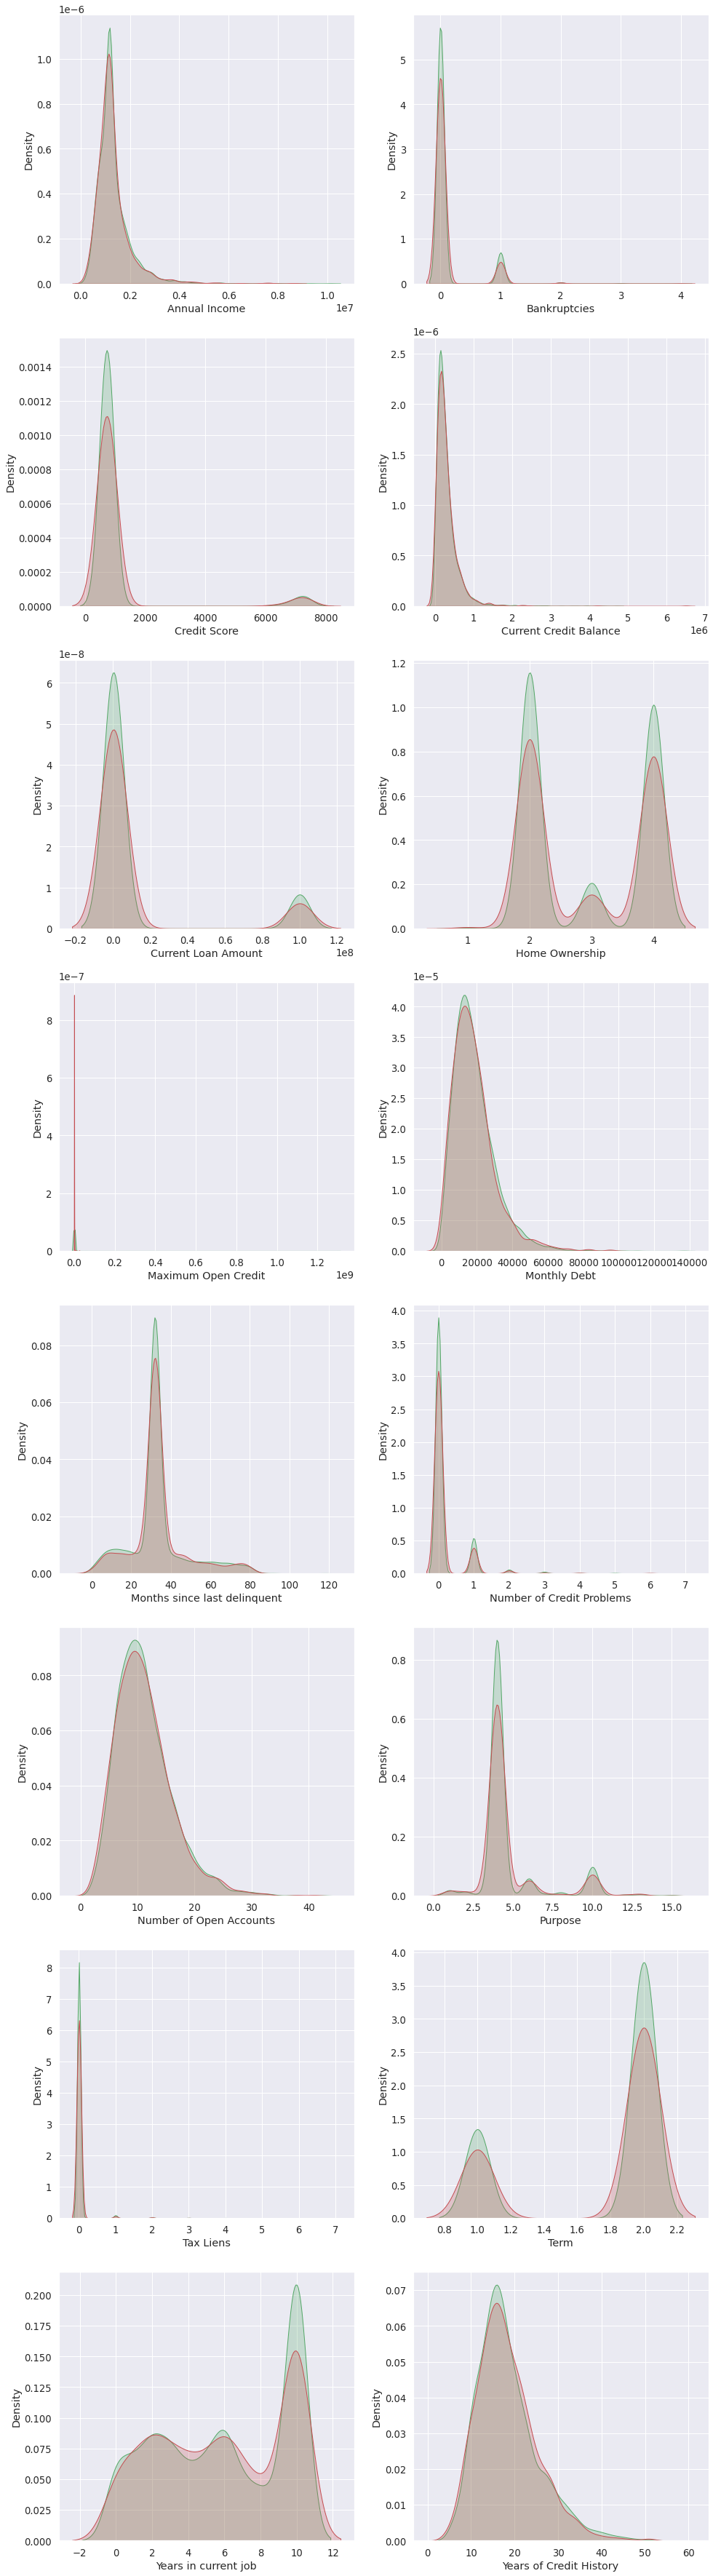

In [44]:
sns_kdeplot_compare(X_train, X_valid)

---
[Наверх](#content)

## 10. Построение модели<a class="anchor" id="model"></a>
---

### Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a> 

*LightGBM*

In [45]:
%%time
model_LGBM = lgbm.LGBMClassifier(random_state=42, 
                                 class_weight={0:1, 1:3.6},
#                                  n_estimators=100
                                )
model_LGBM.fit(X_train, y_train)

clf_evaluate_preds(model_LGBM, X_train, X_valid, y_train, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.83      0.90      4310
           1       0.69      0.99      0.81      1690

    accuracy                           0.87      6000
   macro avg       0.84      0.91      0.86      6000
weighted avg       0.91      0.87      0.88      6000

TEST

              precision    recall  f1-score   support

           0       0.84      0.67      0.74      1077
           1       0.44      0.66      0.53       423

    accuracy                           0.67      1500
   macro avg       0.64      0.67      0.64      1500
weighted avg       0.72      0.67      0.68      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               722  355
1               142  281
CPU times: user 2.57 s, sys: 54 ms, total: 2.62 s
Wall time: 232 ms


*CatBoost*

In [46]:
%%time
model_catb = catb.CatBoostClassifier(silent=True, random_state=42)
model_catb.fit(X_train, y_train)

clf_evaluate_preds(model_catb, X_train, X_valid, y_train, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.99      0.92      4310
           1       0.96      0.56      0.71      1690

    accuracy                           0.87      6000
   macro avg       0.91      0.78      0.81      6000
weighted avg       0.88      0.87      0.86      6000

TEST

              precision    recall  f1-score   support

           0       0.78      0.94      0.85      1077
           1       0.69      0.32      0.43       423

    accuracy                           0.77      1500
   macro avg       0.73      0.63      0.64      1500
weighted avg       0.75      0.77      0.73      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1016   61
1                289  134
CPU times: user 17.4 s, sys: 7.01 s, total: 24.4 s
Wall time: 5.17 s


### Подготовка для catboost

In [47]:
X_train[CAT_FEATURE_NAMES] = X_train[CAT_FEATURE_NAMES].astype(np.int8)
X_valid[CAT_FEATURE_NAMES] = X_valid[CAT_FEATURE_NAMES].astype(np.int8)
X_test[CAT_FEATURE_NAMES] = X_test[CAT_FEATURE_NAMES].astype(np.int8)

In [54]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=42,
                                     cat_features=CAT_FEATURE_NAMES)
model_catb.fit(X_train, y_train)

clf_evaluate_preds(model_catb, X_train, X_valid, y_train, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.99      0.90      4310
           1       0.94      0.46      0.62      1690

    accuracy                           0.84      6000
   macro avg       0.88      0.72      0.76      6000
weighted avg       0.86      0.84      0.82      6000

TEST

              precision    recall  f1-score   support

           0       0.78      0.96      0.86      1077
           1       0.74      0.32      0.45       423

    accuracy                           0.78      1500
   macro avg       0.76      0.64      0.65      1500
weighted avg       0.77      0.78      0.74      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1029   48
1                288  135


In [49]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5502958579881656

In [50]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=42,
                                     cat_features=CAT_FEATURE_NAMES,
                                     class_weights=[1, disbalance])
model_catb.fit(X_train, y_train)

clf_evaluate_preds(model_catb, X_train, X_valid, y_train, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.93      0.85      0.89      4310
           1       0.69      0.82      0.75      1690

    accuracy                           0.84      6000
   macro avg       0.81      0.84      0.82      6000
weighted avg       0.86      0.84      0.85      6000

TEST

              precision    recall  f1-score   support

           0       0.82      0.77      0.79      1077
           1       0.49      0.57      0.53       423

    accuracy                           0.71      1500
   macro avg       0.66      0.67      0.66      1500
weighted avg       0.73      0.71      0.72      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               827  250
1               181  242


---
[Наверх](#content)

## 11. Подбор лучшей модели CatBoost<a class="anchor" id="best_model"></a>
---

In [55]:
frozen_params = {
     'silent':True,
     'random_state':42,
     'class_weights':[1, disbalance], 
     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20,
     'use_best_model':True,
     'custom_metric':['Precision', 'Recall']
}

model_catb = catb.CatBoostClassifier(**frozen_params)

In [56]:
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_valid, y_valid))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [58]:
model_catb.best_score_

{'learn': {'Recall:use_weights=false': 0.6662721893491125,
  'Logloss': 0.5206290916996004,
  'F1': 0.7116252428207036,
  'Precision:use_weights=false': 0.5588089330024814,
  'Precision:use_weights=true': 0.7636036339259628,
  'Recall:use_weights=true': 0.6662721893491125},
 'validation': {'Recall:use_weights=false': 0.6193853427895981,
  'Logloss': 0.5505187528234384,
  'F1': 0.6638780197767152,
  'Precision:use_weights=false': 0.5217391304347826,
  'Precision:use_weights=true': 0.7355994858300215,
  'Recall:use_weights=true': 0.6193853427895981}}

In [59]:
clf_evaluate_preds(model_catb, X_train, X_valid, y_train, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.78      0.81      4310
           1       0.53      0.63      0.58      1690

    accuracy                           0.74      6000
   macro avg       0.69      0.71      0.70      6000
weighted avg       0.76      0.74      0.75      6000

TEST

              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1077
           1       0.50      0.62      0.55       423

    accuracy                           0.72      1500
   macro avg       0.67      0.69      0.67      1500
weighted avg       0.74      0.72      0.72      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               811  266
1               161  262


---
[Наверх](#content)

## 11. Предсказание на тестовых данных<a class="anchor" id="prediction"></a>
---

In [60]:
pred_test = model_catb.predict(X_test)
submition = pd.DataFrame(zip(X_test.index, pred_test), columns=['Id', TARGET_NAME])
submition.to_csv(SUBMISSION_PATH + 'submition.csv', index=False)

*kaggle public score 0.55030*

---
[Наверх](#content)